# Is the SAT unfair?  Exploring and visualizing the data to find out

### Goal of this project  

We are going to explore SAT results and NYC high school data to examine if the SAT is unfair to any particular groups of students.


### Approach


### Summary of results



# Introduction to the data

The data file `"nyc_hs_data_clean.csv"`, located in the `"data/processed"` folder of this project, was produced by running the [cleaning-nyc-hs-data](https://github.com/JustinToribio/cleaning-nyc-hs-data) project, which can also be found in this GitHub repository.  We will read the csv file into a dataframe named `data` and view the first 5 rows.

There are 362 rows (1 for each school) and 79 columns in `data`, which contains NYC SAT results by school for the graduating seniors of 2012 in the first few columns.  At the time of this writing, this was the most recent SAT data available.  The remaining columns contain graduation, AP (advanced placement), class size, demographic, school survey and location data for the same school year (or as close to it as possible if the 2012 data was not available).

In [1]:
# Import pandas module and set maximum viewable columns and rows to 500.
import pandas as pd
pd.options.display.max_columns = 500  
pd.options.display.max_rows = 500

# Read csv file into a dataframe named "data" and view the first 5 rows.
data = pd.read_csv("../data/processed/nyc_hs_data_clean.csv")
data.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29.0,355.0,404.0,363.0,1122.0,78.0,43.0,55.1,36.0,46.2,83.7,0.0,0.0,0.0,36.0,46.2,83.7,7.0,9.0,16.3,16.0,20.5,11.0,14.1,18.096134,19.175354,13.554735,88.000000,4.000000,22.564286,18.500000,26.571429,88.6,422.0,94.0,22.3,105.0,24.9,34.0,35.0,59.0,14.0,123.0,29.1,227.0,53.8,7.0,1.7,259.0,61.4,163.0,38.6,89.0,70.0,39.0,379.000000,26.0,151.0,6.00000,6.3,7.8,6.7,6.100000,6.1,7.4,6.6,6.700000,6.5,7.6,7.0,5.600000,5.3,7.7,6.2,40.713764,-73.985260,1
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91.0,383.0,423.0,366.0,1172.0,124.0,53.0,42.7,42.0,33.9,79.2,8.0,6.5,15.1,34.0,27.4,64.2,11.0,8.9,20.8,46.0,37.1,20.0,16.1,37.000000,53.000000,21.000000,105.687500,4.750000,22.231250,18.250000,27.062500,71.8,394.0,83.0,21.1,86.0,21.8,55.0,10.0,115.0,29.2,89.0,22.6,181.0,45.9,9.0,2.3,226.0,57.4,168.0,42.6,84.0,95.0,10.0,385.000000,37.0,46.0,6.00000,6.6,7.9,6.8,6.300000,6.6,7.2,6.7,7.000000,7.3,7.3,7.2,5.700000,5.8,7.4,6.3,40.712332,-73.984797,1
2,01M450,EAST SIDE COMMUNITY SCHOOL,70.0,377.0,402.0,370.0,1149.0,90.0,70.0,77.8,67.0,74.4,95.7,0.0,0.0,0.0,67.0,74.4,95.7,3.0,3.3,4.3,15.0,16.7,5.0,5.6,12.000000,12.000000,20.562084,57.600000,2.733333,21.200000,19.400000,22.866667,71.8,598.0,30.0,5.0,158.0,26.4,91.0,19.0,58.0,9.7,143.0,23.9,331.0,55.4,62.0,10.4,327.0,54.7,271.0,45.3,0.0,98.0,28.0,422.207196,42.0,150.0,6.79888,7.3,8.7,7.9,6.832925,8.0,8.1,7.9,7.594217,8.8,8.4,8.4,6.151669,8.0,8.2,7.9,40.729783,-73.983041,1
3,01M509,MARTA VALLE HIGH SCHOOL,44.0,390.0,433.0,384.0,1207.0,84.0,47.0,56.0,40.0,47.6,85.1,17.0,20.2,36.2,23.0,27.4,48.9,7.0,8.3,14.9,25.0,29.8,5.0,6.0,14.000000,15.000000,13.779655,69.642857,3.000000,23.571429,20.000000,27.357143,80.7,367.0,41.0,11.2,95.0,25.9,28.0,36.0,34.0,9.3,116.0,31.6,209.0,56.9,6.0,1.6,170.0,46.3,197.0,53.7,90.0,100.0,21.0,306.000000,29.0,69.0,6.40000,6.4,7.7,6.9,6.400000,6.1,7.2,6.6,7.000000,6.8,7.3,7.0,5.900000,5.3,7.4,6.2,40.720569,-73.985673,1
4,01M539,"NEW EXPLORATIONS INTO SCIENCE, TECHNOLOGY AND ...",159.0,522.0,574.0,525.0,1621.0,46.0,46.0,100.0,46.0,100.0,100.0,31.0,67.4,67.4,15.0,32.6,32.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,306.000000,587.000000,323.000000,156.368421,6.157895,25.510526,19.473684,31.210526,23.0,1613.0,4.0,0.2,43.0,2.7,2.0,0.0,448.0,27.8,189.0,11.7,229.0,14.2,725.0,44.9,794.0,49.2,819.0,50.8,98.0,68.0,51.0,923.000000,67.0,736.0,7.30000,7.6,8.5,7.8,7.000000,5.9,7.9,6.9,7.700000,7.3,8.4,7.8,6.400000,5.6,7.9,6.7,40.718725,-73.979426,1


# Finding columns correlated with SAT scores  

We will begin by determining which columns are most strongly correlated with SAT scores.  We will do this by looking at the correlation coefficient between each column and the `"sat_score"` column.  

The correlation coefficient measures the strength and direction of a linear relationship between two quantitative variables.  The maximum possible value is +1, indicating a perfect positive linear relationship (as one variable increases, the other variable *increases* in linear proportion).  The minimum possible value is –1, indicating a perfect negative linear relationship (as one variable increases, the other variable *decreases* in linear proportion).  A coefficient of 0 indicates no linear relationship between the two variables.

Since we only care about strong correlations, we will view columns that have a coefficient with `"sat_score"` greater than 0.5 or less than -0.5. 

In [2]:
# View the columns that have a correlation coefficient 
# with "sat_score" greater than 0.5 or less than -0.5.
correlations = data.corr()["sat_score"]
filtered_correlations = correlations[abs(correlations) > 0.5]
filtered_correlations

SAT Critical Reading Avg. Score    0.986698
SAT Math Avg. Score                0.972543
SAT Writing Avg. Score             0.987755
sat_score                          1.000000
Total Grads - % of cohort          0.603151
Total Regents - n                  0.506568
Total Regents - % of cohort        0.704099
Total Regents - % of grads         0.537477
Advanced Regents - n               0.598048
Advanced Regents - % of cohort     0.795067
Advanced Regents - % of grads      0.763957
Local - % of cohort               -0.514678
Local - % of grads                -0.537477
Still Enrolled - % of cohort      -0.517586
Num of AP Test Takers              0.590119
Num of AP Total Exams Taken        0.580490
Num of AP Exams Passed             0.576238
frl_percent                       -0.734893
asian_per                          0.569673
white_per                          0.636848
Name: sat_score, dtype: float64

# Selecting columns to explore further

### SAT score columns  

The first 4 column names in the list above pertain to SAT scores, which is our target variable, so we will drop all of these columns.  We are interested in exploring which *other* columns are correlated with SAT scores.

### Graduation data columns  

The 5th through 14th column names in the list above (`"Total Grads - % of cohort"` to `"Still Enrolled - % of cohort"`) all pertain to graduation data.  Thus, we will select the most positively correlated column (`"Advanced Regents - % of cohort"`) and most negatively correlated column (`"Local - % of grads"`) to explore further and drop the rest since they all provide related information.  

### AP data columns  

The 15th through 17th column names in the list above (`"Num of AP Test Takers"` to `"Num of AP Exams Passed"`) all pertain to AP results data.  We will select the most positively correlated column (`"Num of AP Test Takers"`) to explore further and drop the rest since they all provide related information.  

### Demographic data columns  

The last 3 column names in the list above all pertain to demographic data.  We will select all of these columns to explore further since each gives information on a different demographic group.  
 
Finally, we will view the final selected columns along with their corresponding correlation coefficients with `"sat_score"`.

In [3]:
# Create a list of columns to drop.
drop_columns = [
    "sat_score", 
    "SAT Writing Avg. Score",
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "Total Grads - % of cohort",
    "Total Regents - n",
    "Total Regents - % of cohort",
    "Total Regents - % of grads",
    "Advanced Regents - n",
    "Advanced Regents - % of grads",
    "Local - % of cohort",
    "Still Enrolled - % of cohort",
    "Num of AP Total Exams Taken",
    "Num of AP Exams Passed"
]

# Drop the columns to be removed and view the final selected columns.
filtered_correlations.drop(drop_columns, inplace=True)
filtered_correlations

Advanced Regents - % of cohort    0.795067
Local - % of grads               -0.537477
Num of AP Test Takers             0.590119
frl_percent                      -0.734893
asian_per                         0.569673
white_per                         0.636848
Name: sat_score, dtype: float64

# Exploring graduation data and SAT scores  

There are three different categories of high school diplomas offered to graduating students in New York State: a regular diploma called the Regents, the Regents Diploma with Advanced Designation, and the Local Diploma, which is an option for some students with disabilities.  A Regents Diploma is earned upon successful completion of the Regents Exams, which are statewide standardized examinations in the required subjects.    

### Percentage of total Cohorts that passed the Advanced Regents Exam

The `"Advanced Regents - % of cohort"` column represents the percentages of total Cohorts (students in the same graduating year) that passed the Advanced Regents Exam in each school.  


**(findings???)** It is reasonable to expect that a high % of students who pass the Advanced Regents Exam would correlate with high SAT scores.  

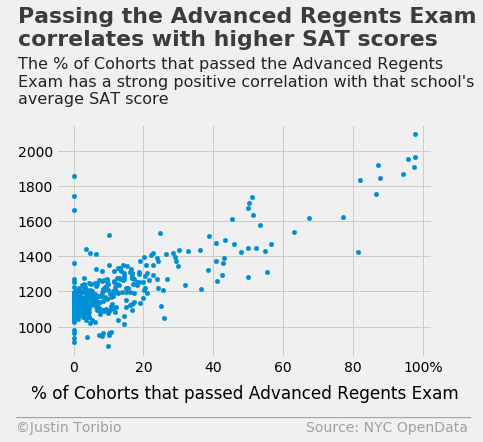

In [152]:
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

# Plot graph with customizations.
style.use("fivethirtyeight")
graph = data.plot.scatter(x="Advanced Regents - % of cohort", y="sat_score")
graph.set_xticklabels(labels=["-20", "0", "20", "40", "60", "80", "100%"])
graph.yaxis.label.set_visible(False)

graph.text(x=-19, y=500, color="grey", alpha=.7, 
           s="  _________________________________________________________________")

graph.text(x=-19, y=400, fontsize=14, color="grey", alpha = .7,
           s="  ©Justin Toribio                                         Source: NYC OpenData ")

#graph.set_title("Passing the Advanced Regents Exam = high SAT scores")
graph.set_xlabel("% of Cohorts that passed Advanced Regents Exam", labelpad=10)
graph.set_ylabel("Avg SAT Score")

graph.text(x=-16, y=2600, fontsize=22, weight="bold", alpha=.75, 
           s="Passing the Advanced Regents Exam\ncorrelates with higher SAT scores")

graph.text(x=-16, y=2270, fontsize=16, alpha=.85,
           s="The % of Cohorts that passed the Advanced Regents\nExam has a strong positive correlation with that school's\naverage SAT score")

plt.show()

In [17]:
import numpy as np

districts = data.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head()

,school_dist,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,Total Cohort,Total Grads - n,Total Grads - % of cohort,Total Regents - n,Total Regents - % of cohort,Total Regents - % of grads,Advanced Regents - n,Advanced Regents - % of cohort,Advanced Regents - % of grads,Regents w/o Advanced - n,Regents w/o Advanced - % of cohort,Regents w/o Advanced - % of grads,Local - n,Local - % of cohort,Local - % of grads,Still Enrolled - n,Still Enrolled - % of cohort,Dropped Out - n,Dropped Out - % of cohort,Num of AP Test Takers,Num of AP Total Exams Taken,Num of AP Exams Passed,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,frl_percent,total_enrollment,ell_num,ell_percent,sped_num,sped_percent,ctt_num,selfcontained_num,asian_num,asian_per,black_num,black_per,hispanic_num,hispanic_per,white_num,white_per,male_num,male_per,female_num,female_per,rr_s,rr_t,rr_p,N_s,N_t,N_p,saf_s_11,saf_t_11,saf_p_11,saf_tot_11,eng_s_11,eng_t_11,eng_p_11,eng_tot_11,aca_s_11,aca_t_11,aca_p_11,aca_tot_11,com_s_11,com_t_11,com_p_11,com_tot_11,lat,lon
0,1,87.166667,441.833333,473.333333,439.333333,1354.500000,93.500000,65.500000,71.333333,60.833333,66.416667,90.616667,9.333333,15.683333,19.783333,51.500000,50.733333,70.850000,4.666667,4.916667,9.383333,17.666667,17.833333,7.000000,7.083333,84.291336,139.752637,84.333827,115.244241,5.148538,22.675415,18.798392,26.553044,58.983333,668.500000,42.166667,10.000000,82.000000,17.083333,35.000000,16.666667,134.500000,17.516667,125.500000,22.333333,214.833333,40.733333,186.000000,18.450000,328.166667,50.050000,340.333333,49.950000,76.500000,85.333333,33.166667,496.034533,38.500000,239.166667,6.799813,7.066667,8.233333,7.433333,6.772154,6.700000,7.683333,7.116667,7.482369,7.500000,8.016667,7.683333,6.175278,6.233333,7.800000,6.816667,40.719022,-73.982377
1,2,109.337557,423.269446,438.595848,421.100185,1282.965479,138.697428,107.862897,75.666297,94.222360,64.302408,84.304987,35.251348,17.121937,19.667211,58.971012,47.169667,64.636568,13.640538,11.378324,15.695013,19.582217,14.611029,9.078776,7.215021,95.779461,146.635567,96.610208,149.818949,5.686360,25.038118,20.662667,28.593861,63.164583,605.604167,51.625000,13.006250,70.770833,13.212500,36.166667,11.541667,118.395833,14.479167,141.145833,24.733333,271.458333,49.554167,68.541667,10.056250,266.500000,44.718750,339.104167,55.281250,83.312500,86.416667,38.333333,489.850536,31.687500,190.000000,6.926629,7.404167,8.254167,7.520833,6.655288,7.120833,7.379167,7.037500,7.389787,7.564583,7.704167,7.541667,6.212715,6.520833,7.495833,6.720833,40.739699,-73.991386
2,3,111.330361,422.879310,428.509107,420.261663,1271.650079,149.088357,124.998519,73.870669,114.447834,62.946544,83.858510,35.486907,13.692338,16.475399,78.960927,49.263644,67.401518,10.550685,10.917248,16.141490,16.536632,15.611714,6.920222,7.279957,121.365416,189.175742,125.462201,156.005994,5.839200,23.716311,19.737593,27.122831,58.050000,661.416667,36.916667,9.025000,63.583333,14.500000,21.250000,15.583333,68.000000,6.408333,181.833333,34.000000,228.250000,44.533333,172.000000,13.725000,272.166667,47.950000,389.250000,52.050000,83.166667,80.833333,36.166667,519.250000,28.166667,206.416667,6.716667,6.675000,8.316667,7.233333,6.633333,6.533333,7.508333,6.891667,7.375000,6.991667,7.758333,7.391667,6.258333,5.991667,7.541667,6.616667,40.781574,-73.977370
3,4,108.000000,397.166667,411.333333,398.666667,1207.166667,123.666667,96.000000,72.300000,79.666667,52.750000,69.966667,37.833333,13.716667,16.266667,41.833333,39.033333,53.700000,16.333333,19.550000,30.033333,17.666667,16.983333,6.500000,7.633333,76.362637,102.588809,60.413375,143.040289,5.607065,23.832596,19.197619,27.380143,71.616667,589.333333,23.500000,4.950000,63.333333,14.300000,30.000000,11.000000,67.500000,6.300000,153.666667,29.833333,353.500000,61.616667,9.666667,1.266667,225.500000,35.600000,363.833333,64.400000,88.000000,92.16666

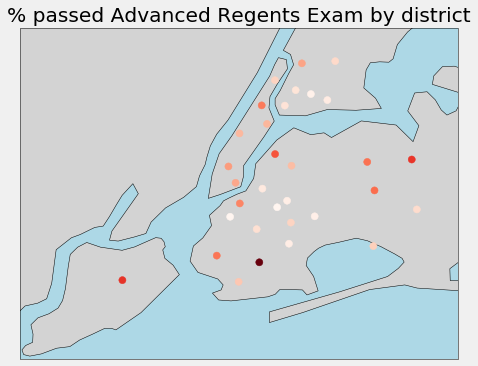

In [41]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none', category='cultural'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.background_patch.set_facecolor("lightblue")
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.set_title("% passed Advanced Regents Exam by district")
ax.scatter(longitudes, latitudes, s=50, zorder=2, cmap="Reds", 
           c=districts["Advanced Regents - % of cohort"])
# add the "Reds" color gradient as a legend, with "low" and "high" labels

### Percentage of total Cohorts that graduated with a Local Diploma  

A Local Diploma is an option for students who can't get above a score of 65 on all of their Regents Exams, but can get above at least a 45.

`"Local - % of grads"` represents the percentage of total Cohorts that graduated with a Local Diploma in each school.  It is reasonable to expect that a high % of students who graduate with a Local Diploma would correlate with low SAT scores.  

# Exploring AP data and SAT scores  

`"Num of AP Test Takers"` represents the number of students that have taken AP tests.

In [ ]:
data.plot(x="total_enrollment", y="sat_score", kind="scatter")
correlations["total_enrollment"]

# Exploring schools with low SAT scores and enrollment... why am I plotting this???

In [ ]:
low_enrollment = data[data["total_enrollment"] < 1000]
low_enrollment = data[data["sat_score"] < 1000]
print(low_enrollment.shape)
low_enrollment[["SCHOOL NAME", "total_enrollment", "sat_score"]]

# Plotting language learning percentage

In [ ]:
data.plot(x="ell_percent", y="sat_score", kind="scatter")
correlations["ell_percent"]

# Mapping the schools

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

fig = plt.figure(figsize=(7,7))

# make this subplot a little bit wider somehow??? Or figure out how to change cartopy subplot bg color
ax1 = fig.add_subplot(111)
ax1.set_facecolor("lightblue")
ax1.tick_params(
    axis='both', which='both', bottom=False,
    top=False, left=False, right=False,
    labelleft=False, labelbottom=False
    )

ax2 = fig.add_subplot(111, projection=ccrs.Mercator())
ax2.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax2.background_patch.set_fill(False)
ax2.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

In [ ]:
import cartopy.crs as ccrs
import cartopy.feature as cfeat

fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = data["lon"].tolist()
latitudes = data["lat"].tolist()

ax.scatter(longitudes, latitudes, transform=ccrs.PlateCarree(), s=20, zorder=4)

# Plotting out statistics

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

ax.scatter(longitudes, latitudes, s=20, zorder=2, c=data["ell_percent"], cmap="summer")

# Calculating district level statistics

In [ ]:
import numpy as np

districts = data.groupby("school_dist").agg(np.mean)
districts.reset_index(inplace=True)

districts.head()

# Plotting "percent of English learners" by district

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["ell_percent"], cmap="summer")

# Correlation between survey results and SAT scores

In [ ]:
survey_fields_with_SAT = [
    "DBN",
    "sat_score",
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
    ]

corr_survey_sat = data.loc[:, survey_fields_with_SAT].corr()
corr_survey_sat = corr_survey_sat["sat_score"][1:]

corr_survey_sat.plot.barh()

Mine: Academic expectations and safety and respect scores have strong r-values with SAT scores. Makes sense, hard to learn in an unsafe environment, and I'd expect high achieving students with high expectations of a school to perform well academically at that school.

Solution: There are high correlations between N_s, N_t, N_p and sat_score. Since these columns are correlated with total_enrollment, it makes sense that they would be high.

It is more interesting that rr_s, the student response rate, or the percentage of students that completed the survey, correlates with sat_score. This might make sense because students who are more likely to fill out surveys may be more likely to also be doing well academically.

How students and teachers perceived safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

The last interesting correlation is the aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.

# Exploring safety and SAT scores

In [ ]:
data.plot.scatter(x="saf_s_11", y="sat_score")

Mine: Doesn't appear to be a strong linear correlations, weak at best.

Solution: There appears to be a correlation between SAT scores and safety, although it isn't that strong. It looks like there are a few schools with extremely high SAT scores and high safety scores. There are a few schools with low safety scores and low SAT scores. No school with a safety score lower than 6.5 has an average SAT score higher than 1500 or so.

In [ ]:
fig = plt.figure(figsize=(7,7))

state_borders = cfeat.NaturalEarthFeature(
    category='cultural', name='admin_1_states_provinces_lakes', 
    scale='10m', facecolor='none'
    )

ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.add_feature(state_borders, edgecolor="black", facecolor="lightgrey")
ax.set_extent((-74.255735, -73.700272, 40.496044, 40.915256))

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()

ax.scatter(longitudes, latitudes, s=50, zorder=2, c=districts["saf_s_11"], cmap="summer")

Mine: Safest schools are in Manhattan as expected. With exception of a few, the least safe schools are in Brooklyn, Queens and the Bronx

Solution: It looks like Upper Manhattan and parts of Queens and the Bronx tend to have lower safety scores, whereas Brooklyn has high safety scores.

# Exploring race and SAT scores

In [ ]:
race_cols = ["sat_score", "white_per", "asian_per", "black_per", "hispanic_per"]
race_sat = data[race_cols].corr()["sat_score"][1:]
race_sat.plot.barh()

Mine: Asian and White are strongly positively correlated. Hispanic and Black are strongly negatively correlated.  Possibly suggests racial bias in test, or indicative of lack of funding for schools in areas with high % of hispanic and black students.

Solution: It looks like a higher percentage of white or asian students at a school correlates positively with sat score, whereas a higher percentage of black or hispanic students correlates negatively with sat score. This may be due to a lack of funding for schools in certain areas, which are more likely to have a higher percentage of black or hispanic students.

In [ ]:
data.plot.scatter("hispanic_per", "sat_score")

Mine: appears to be negative correlation, although not that strong. Schools with greater than approx 25% Hispanic don't have an SAT score above around 1500

In [ ]:
data[data["hispanic_per"] > 95]["SCHOOL NAME"]

Solution: The schools listed above appear to primarily be geared towards recent immigrants to the US. These schools have a lot of students who are learning English, which would explain the lower SAT scores.

In [ ]:
hisp_10_1800 = data[data["hispanic_per"] < 10]
hisp_10_1800[hisp_10_1800["sat_score"] > 1800]["SCHOOL NAME"]

Mine: all appear to be science and technical schools, suggesting higher acceptance requirements, and hence higher achieving students

Solution: Many of the schools above appear to be specialized science and technology schools that receive extra funding, and only admit students who pass an entrance exam. This doesn't explain the low hispanic_per, but it does explain why their students tend to do better on the SAT -- they are students from all over New York City who did well on a standardized test.

# Exploring gender and SAT scores

In [ ]:
sex_cols = ["sat_score", "male_per", "female_per"]
sex_sat = data[sex_cols].corr()["sat_score"][1:]
sex_sat.plot.barh()

Mine: females positive corr, males negative corr, but neither are strong.

Solution: In the plot above, we can see that a high percentage of females at a school positively correlates with SAT score, whereas a high percentage of males at a school negatively correlates with SAT score. Neither correlation is extremely strong.

In [ ]:
data.plot.scatter("female_per", "sat_score")

Mine: don't see any strong linear corr.  There's high and low sat scores with high and low female_per

Solution: Based on the scatter plot, there doesn't seem to be any real correlation between sat_score and female_per. However, there is a cluster of schools with a high percentage of females (60 to 80), and high SAT scores.

In [ ]:
fem_60_1700 = data[data["female_per"] > 60]
fem_60_1700[fem_60_1700["sat_score"] > 1700]["SCHOOL NAME"]

Solution: These schools appears to be very selective liberal arts schools that have high academic standards

# Exploring AP scores vs SAT scores

In [ ]:
data["ap_per"] = data["Num of AP Test Takers"] / data["total_enrollment"]
data.plot.scatter("ap_per", "sat_score")

Mine: some corr but not strong. There is a cluster of schools with ap_per > .4 with high SAT, but also a bunch with very high ap_per with SAT no greater than 1200

Solution: It looks like there is a relationship between the percentage of students in a school who take the AP exam, and their average SAT scores. It's not an extremely strong correlation, though.

# Conclusion